# CNN para la clasificación de fruta

Mario Andrade Téllez 171792

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
#imports necesarios para el uso de

In [ ]:
!gdown 1bTAFhE2JMfPyCfrYNIqPVXlqSQlUbsZE

# Dataset obtenido de: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition

In [ ]:
!unzip data.zip -d Data

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Data/train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_274.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_275.jpg  
  inflating: Data/train/train/Pepper Green/Pepper Green_276.jpg  
  inflating: Dat

## Pre-procesamiento


Los datos originales están clasificados ya como training y test data. Sin embargo, los datos de test (los cuales son imágenes), no tienen su label bien establecido, por lo tanto el modelo no podría saber con certeza si está bien o no, por lo tanto, lo que decidí hacer es una carpeta nueva, "validation" que va a servir como el test set. Estas imágenes vienen desde la carpeta de train, la cuál sí tiene las imágenes bien establecidas con sus labels.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Definimos los directorios
train_dir = '/content/Data/train/train'
validation_dir = '/content/Data/validation'

# Crear directorio
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

# Obtener lista de las clases de fruta
fruit_classes = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]

# Para cada una de las clases, dividir
for fruit_class in fruit_classes:
    fruit_class_dir = os.path.join(train_dir, fruit_class)
    fruit_class_validation_dir = os.path.join(validation_dir, fruit_class)

    # Crear directorio
    if not os.path.exists(fruit_class_validation_dir):
        os.makedirs(fruit_class_validation_dir)

    # Obtener las imágenes
    images = [img for img in os.listdir(fruit_class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]  # Added support for multiple image formats

    if images:
        _, validation_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in validation_images:
            src_path = os.path.join(fruit_class_dir, img)
            dst_path = os.path.join(fruit_class_validation_dir, img)
            shutil.move(src_path, dst_path)
    else:
        print(f"No images found for class {fruit_class}. Check the directory: {fruit_class_dir}")


In [ ]:
!rm -rf '/content/Data/validation/.ipynb_checkpoints' #Eliminación de folder creado para checkpoints (mezclado con las clases más adelante)


## Procesamiento de imágenes

Se procesan las imágenes de los datos, los de práctica y validación.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/Data/train/train',
    target_size=(128, 128),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)


validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    '/content/Data/validation',
    target_size=(128, 128),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)


Found 13471 images belonging to 33 classes.
Found 3383 images belonging to 33 classes.


Se construye y configura un modelo de red neuronal convolucional (CNN) utilizando TensorFlow y Keras. Este modelo está diseñado para la clasificación de imágenes, específicamente para clasificar 33 tipos diferentes de frutas.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(33))  # 33 neurons for 33 fruits
model.add(Activation('softmax'))


Sequential: Un modelo secuencial, que es una pila lineal de capas.


Conv2D, MaxPooling2D: Capas para construir la CNN.

Conv2D es la capa de convolución y MaxPooling2D se usa para reducir la dimensionalidad espacial.


Activation, Dropout, Flatten, Dense: Capas para la activación, regularización, aplanamiento de datos y capas completamente conectadas, respectivamente.


BatchNormalization: Una técnica para mejorar el rendimiento y estabilidad de las redes neuronales. Se añaden capas Dense para la clasificación. La última capa Dense tiene 33 neuronas, una para cada tipo de fruta, y utiliza la función de activación softmax para la clasificación.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)

El modelo se compila con la función de pérdida 'categorical_crossentropy', adecuada para la clasificación multiclase.
Se utiliza el optimizador 'adam'.
Se elige 'accuracy' como métrica para monitorizar el rendimiento del modelo.

EarlyStopping: Detiene el entrenamiento cuando no se observa mejora en el valor de 'val_loss' después de un número específico de épocas ('patience').
ModelCheckpoint: Guarda el modelo en el archivo 'best_model.h5' cada vez que se mejora la 'val_accuracy'.

In [ ]:
import matplotlib.pyplot as plt

Epoch 1/20
420/420 [==============================] - 420s 998ms/step - loss: 2.2159 - accuracy: 0.3331 - val_loss: 0.6231 - val_accuracy: 0.8720
Epoch 2/20
420/420 [==============================] - 396s 944ms/step - loss: 1.0420 - accuracy: 0.6315 - val_loss: 0.2201 - val_accuracy: 0.9411
Epoch 3/20
420/420 [==============================] - 411s 979ms/step - loss: 0.7526 - accuracy: 0.7259 - val_loss: 0.2443 - val_accuracy: 0.9280
Epoch 4/20
420/420 [==============================] - 415s 986ms/step - loss: 0.6147 - accuracy: 0.7708 - val_loss: 0.0641 - val_accuracy: 0.9884
Epoch 5/20
420/420 [==============================] - 411s 978ms/step - loss: 0.5302 - accuracy: 0.8056 - val_loss: 0.0747 - val_accuracy: 0.9824
Epoch 6/20
420/420 [==============================] - 411s 979ms/step - loss: 0.4714 - accuracy: 0.8257 - val_loss: 0.0781 - val_accuracy: 0.9812
Epoch 7/20
420/420 [==============================] - 414s 983ms/step - loss: 0.4665 - accuracy: 0.8308 - val_loss: 0.0890 -

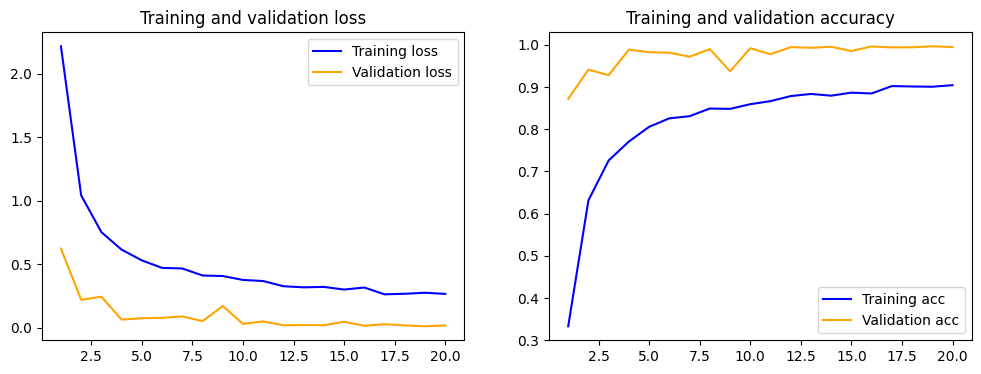

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint]
)



loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


En general, estas gráficas sugieren que tu modelo está teniendo un buen rendimiento. Está aprendiendo a partir de los datos de entrenamiento y, lo que es más importante, está generalizando ese aprendizaje a nuevos datos no vistos, como lo demuestra el seguimiento cercano de las métricas de validación a las métricas de entrenamiento.

Sin embargo, hay algunas cosas a considerar:

Expectativa de Rendimiento: Si la precisión se alinea con lo que se espera o es aceptable para tu dominio del problema, entonces puede considerarse buena.

Consistencia: Hay ligeras fluctuaciones en la precisión de validación, lo cual es normal, pero vale la pena observar si estas fluctuaciones disminuyen con más épocas, indicando estabilidad.

Posible Sobreajuste: Hacia el final de las épocas, la precisión del entrenamiento sigue aumentando ligeramente mientras que la precisión de validación se estanca. Esto podría ser una señal temprana de sobreajuste, incluso si no es pronunciada.

In [ ]:
# Evaluaar modelo
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print('Test accuracy:', test_accuracy)

# Predicción
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)


105/105 [==============================] - 26s 249ms/step - loss: 0.0173 - accuracy: 0.9946
Test accuracy: 0.9946428537368774
105/105 [==============================] - 26s 248ms/step


In [ ]:
model.save('fruit_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
